<a href="https://www.kaggle.com/code/nivedithavudayagiri/mini-course-sales-full-eda-submission?scriptVersionId=136601428" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="color:#9F2B68; font-size:20px">The aim of this competition is to predict a year's worth of sales for various fictitious learning modules from different fictitious Kaggle-branded stores in different countries.</div>

![Image](https://github.com/niveditha-vudayagiri/ny-taxifare-prediction/blob/main/bg.png?raw=true)

# 1.1 Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from holidays import CountryHoliday;
from tqdm.notebook import tqdm;
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder
import requests

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.2 Reading the Data

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
submission_df= pd.read_csv("/kaggle/input/playground-series-s3e19/sample_submission.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [5]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [6]:
#Checking date range in train and test

print(f"\nDate Range in Train: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"\nDate Range in Test: {test_df['date'].min()} to {test_df['date'].max()}")

# Check the list of unique countries in train and test
print("\nUnique countries in Train:", train_df['country'].unique())
print("\nUnique countries in Test:", test_df['country'].unique())

# Check the list of unique stores in train and test
print("\nUnique stores in Train:", train_df['store'].unique())
print("\nUnique stores in Test:", test_df['store'].unique())

# Check the list of unique stores in train and test
print("\nUnique products in Train:", train_df['product'].unique())
print("\nUnique products in Test:", test_df['product'].unique())


Date Range in Train: 2017-01-01 to 2021-12-31

Date Range in Test: 2022-01-01 to 2022-12-31

Unique countries in Train: ['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain']

Unique countries in Test: ['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain']

Unique stores in Train: ['Kaggle Learn' 'Kaggle Store' 'Kagglazon']

Unique stores in Test: ['Kaggle Learn' 'Kaggle Store' 'Kagglazon']

Unique products in Train: ['Using LLMs to Improve Your Coding' 'Using LLMs to Train More LLMs'
 'Using LLMs to Win Friends and Influence People'
 'Using LLMs to Win More Kaggle Competitions' 'Using LLMs to Write Better']

Unique products in Test: ['Using LLMs to Improve Your Coding' 'Using LLMs to Train More LLMs'
 'Using LLMs to Win Friends and Influence People'
 'Using LLMs to Win More Kaggle Competitions' 'Using LLMs to Write Better']


In [7]:
train_df[train_df['date']=='2017-01-01']

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...,...
70,70,2017-01-01,Spain,Kagglazon,Using LLMs to Improve Your Coding,724
71,71,2017-01-01,Spain,Kagglazon,Using LLMs to Train More LLMs,681
72,72,2017-01-01,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,107
73,73,2017-01-01,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,673


In [8]:
def extractDate(df):
    df.date = pd.to_datetime(df.date)
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['dayofmonth'] = df.date.dt.day
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayname'] = df.date.dt.strftime('%A')
    df['dayofyear'] = df.date.dt.dayofyear
    
extractDate(train_df)
extractDate(test_df)

In [9]:
#Check for missing dates

print(pd.date_range(start="2017-01-01", end="2021-12-31").difference(train_df.date))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


# 1.3 Exploratory Data Analysis

# 1.3.1 Yearly sales by product type

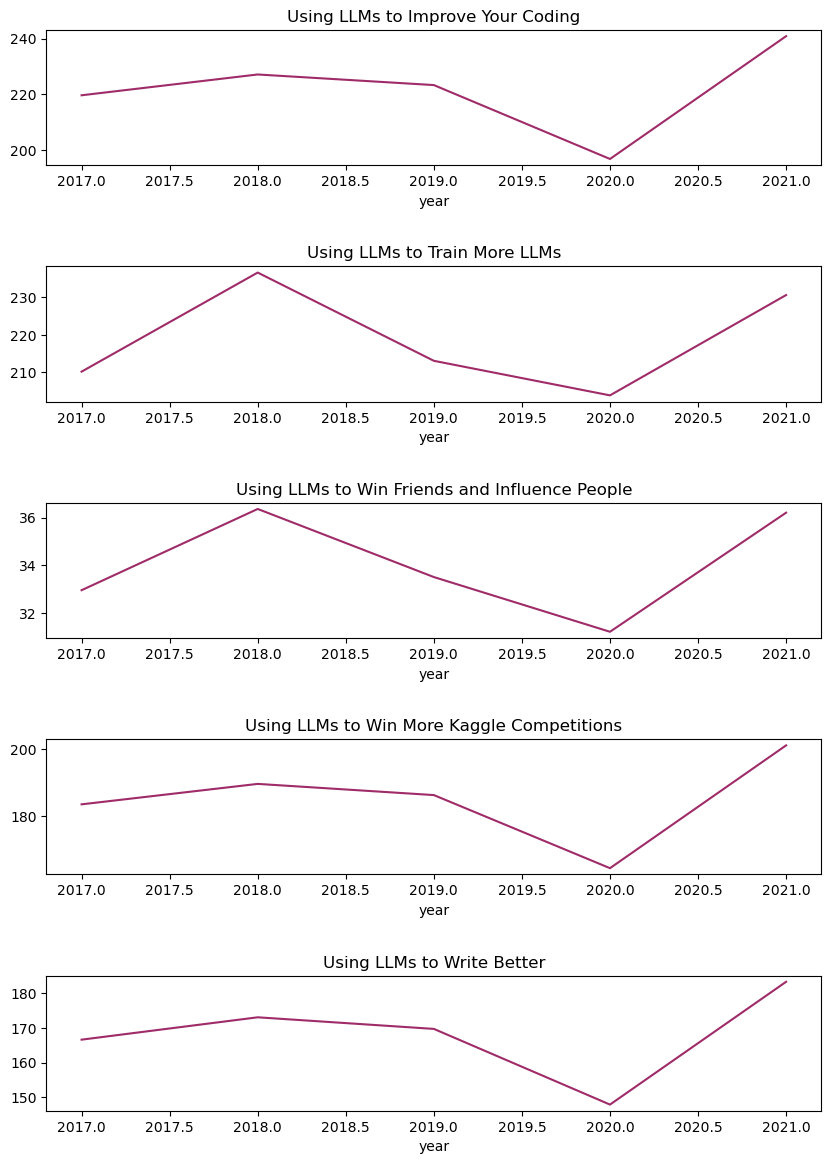

In [10]:
fig= plt.figure(figsize=(10,100))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(train_df['product'].unique()):
    ax = fig.add_subplot(33,1,i+1)
    # create the time series plot
    prod_select = train_df.query('product==@product')
    prod_select.groupby(['year']).num_sold.mean().plot(color=['#9F2B68'])
    plt.title(product)

<div style="color:#9F2B68; font-size:20px">All the books seem to have seen a major dip in 2020.
    <br/>
COVID hit our fictional sales too?</div>

# 1.3.2 Monthly Sales by Product

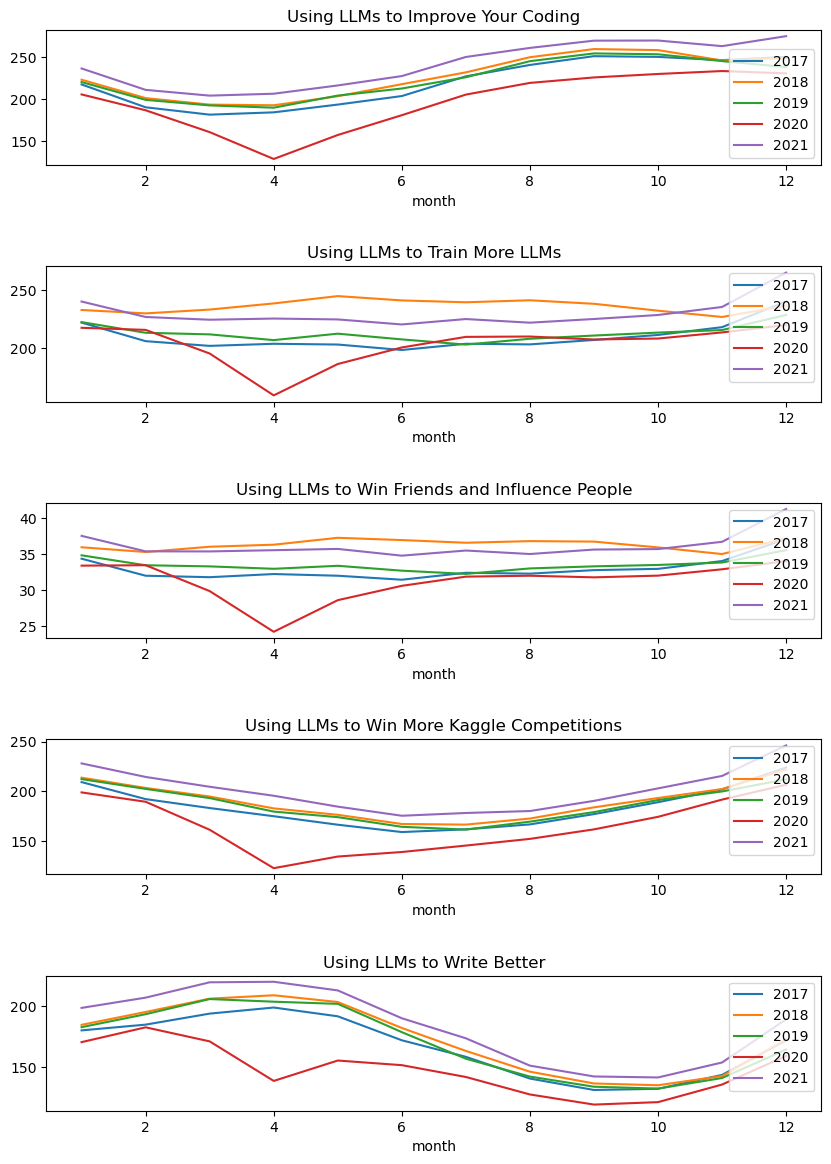

In [11]:
fig= plt.figure(figsize=(10,100))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(train_df['product'].unique()):
    ax = fig.add_subplot(33,1,i+1)
    # create the time series plot
    prod_select = train_df.query('product==@product')
    for year in train_df['year'].unique():
        prod_select.query('year==@year').groupby('month').num_sold.mean().plot(ax=ax,label=year)
    plt.title(product)
    ax.legend();

<div style="color:#9F2B68; font-size:20px">
- Each book seems to have a different seasonality trend.<br/>
- But <b>year end sales</b>(Christmas and new year) is something common across all products.<br/>
- April 2020 shows a major dip across all books. COVID?<br/>
    </div>

# 1.3.3 Monthly Sales by Store

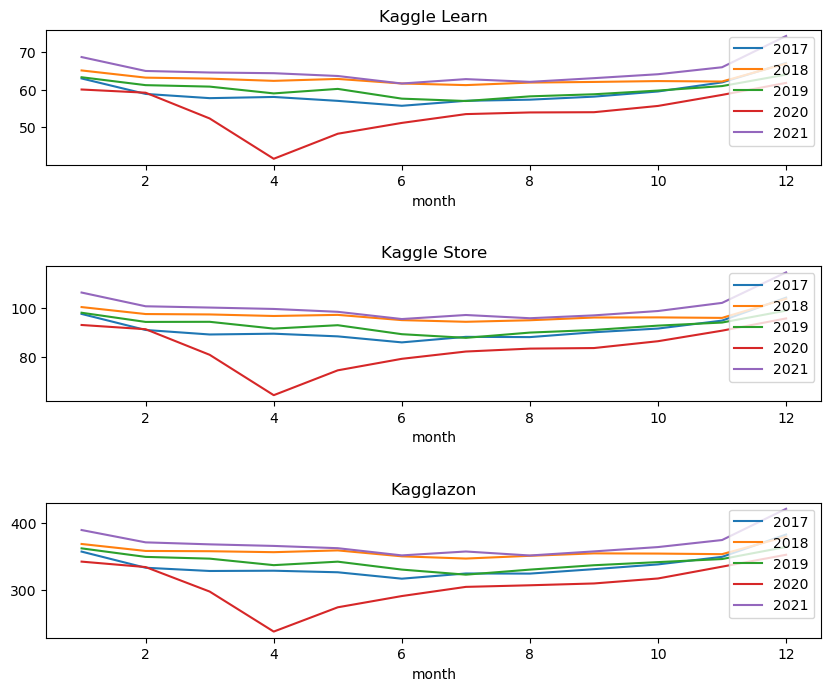

In [12]:
fig= plt.figure(figsize=(10,100))
fig.subplots_adjust(hspace=0.75)
for i,store in enumerate(train_df['store'].unique()):
    ax = fig.add_subplot(33,1,i+1)
    # create the time series plot
    prod_select = train_df.query('store==@store')
    for year in train_df['year'].unique():
        prod_select.query('year==@year').groupby('month').num_sold.mean().plot(ax=ax,label=year)
    plt.title(store)
    ax.legend();

<div style="color:#9F2B68; font-size:20px">
The trends seem to be unusually similar across all stores.

In terms of num_sold, <b>Kagglazon</b> performs better compared to the other two stores.
</div>

# 1.3.4 Sales By Day of Week

Text(0.5, 1.0, 'Average Sales by Day of week')

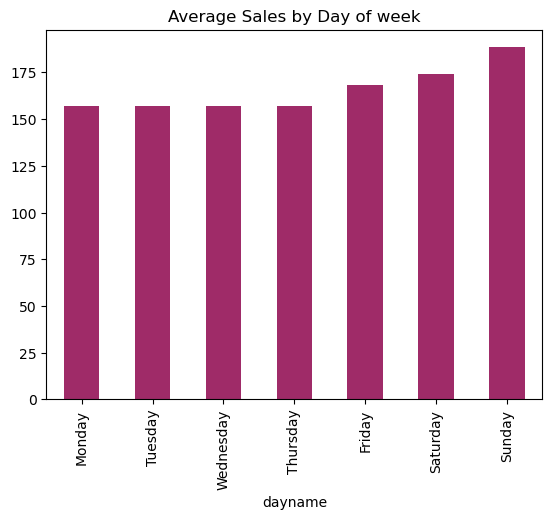

In [13]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
bars = train_df.groupby('dayname').num_sold.mean().reindex(index=order).plot(kind='bar',color=['#9F2B68'])
plt.title('Average Sales by Day of week')

<div style="color:#9F2B68; font-size:20px">
As expected, <b>weekends</b> seem to have more sales.</div>

# 1.3.5 Sales by Country

Text(0.5, 1.0, 'Average Sales Ranking by Country')

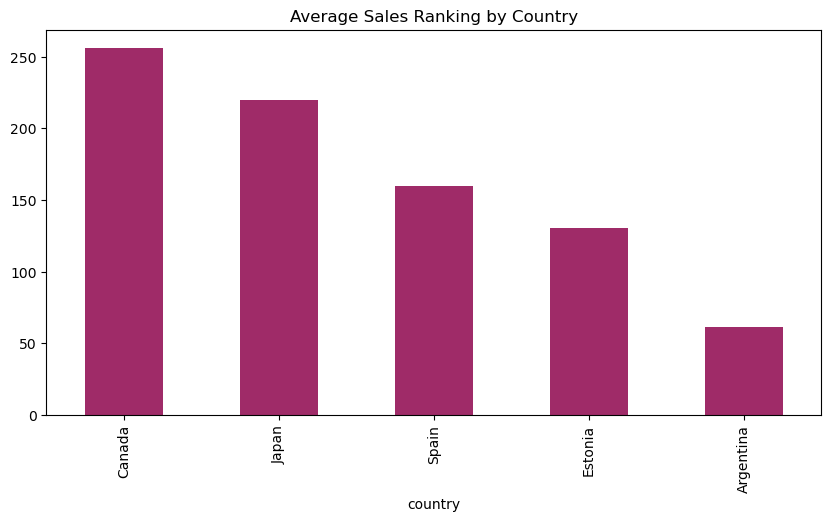

In [14]:
plt.figure(figsize=(10,5))

train_df.groupby('country').num_sold.mean().sort_values(ascending=False).plot(kind='bar',color=['#9F2B68'])
plt.title('Average Sales Ranking by Country')

# 1.3.6 Overall Sales by Product

Text(0.5, 1.0, 'Total Sales Ranking by Product')

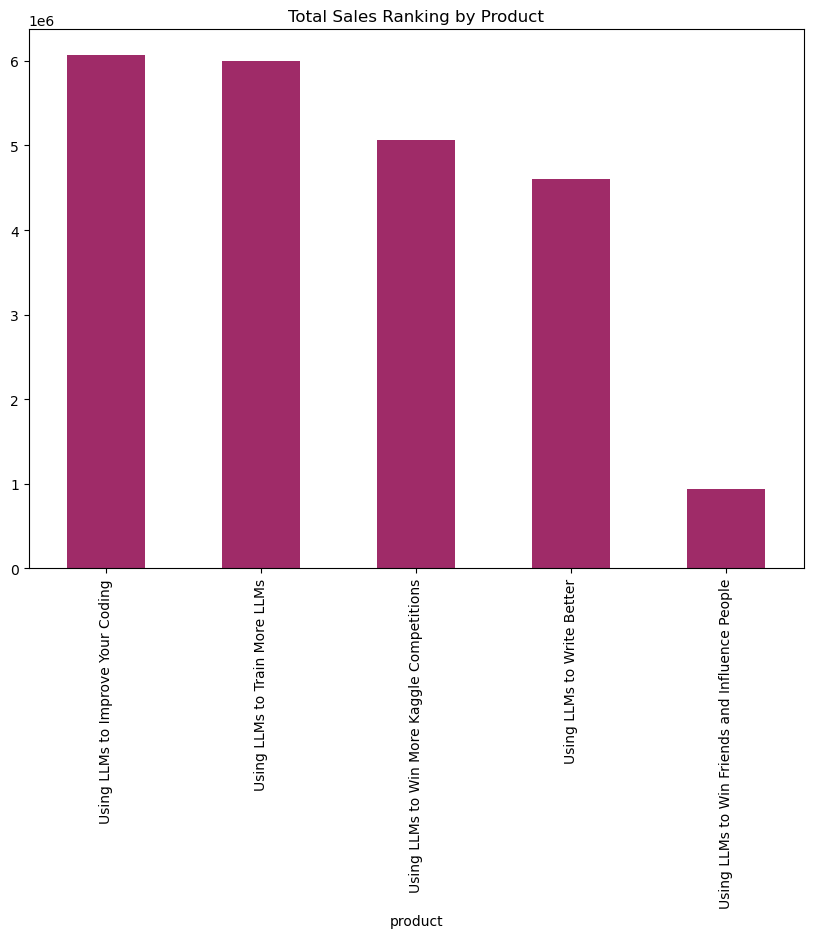

In [15]:
plt.figure(figsize=(10,7))

train_df.groupby('product').num_sold.sum().sort_values(ascending=False).plot(kind='bar',color=['#9F2B68'])
plt.title('Total Sales Ranking by Product')

<div style="color:#9F2B68; font-size:20px">
    <b>Using LLMs to Improve your Coding</b> is the best sold book overall.
    </div>

# 1.3.7 Monthly Sales by Country

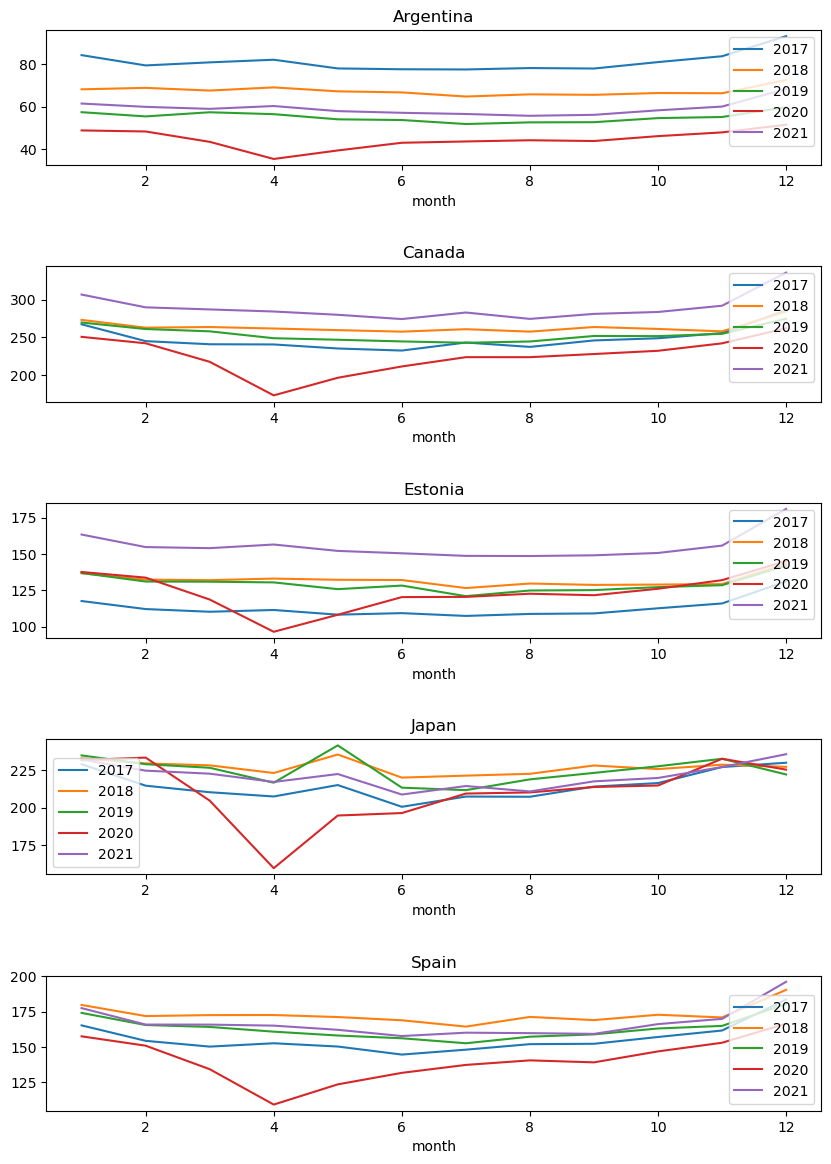

In [16]:
fig= plt.figure(figsize=(10,100))
fig.subplots_adjust(hspace=0.75)
for i,country in enumerate(train_df['country'].unique()):
    ax = fig.add_subplot(33,1,i+1)
    # create the time series plot
    prod_select = train_df.query('country==@country')
    for year in train_df['year'].unique():
        prod_select.query('year==@year').groupby('month').num_sold.mean().plot(ax=ax,label=year)
    plt.title(country)
    ax.legend();

<div style="color:#9F2B68; font-size:20px">We can consider 
    <b>Feb 2020 to June 2020</b> as crisis period.
    </div>

# 1.4.0 Analysing Seasonality

In [17]:
#Average sales get the overall sales of all books across all countries and stores in each day

store_sales = train_df.set_index('date').to_period('D')

store_sales = store_sales.set_index(['country', 'store','product'], append=True)
average_sales = store_sales.groupby('date').mean()['num_sold']

/tmp/ipykernel_20/3258267821.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_sales = store_sales.groupby('date').mean()['num_sold']


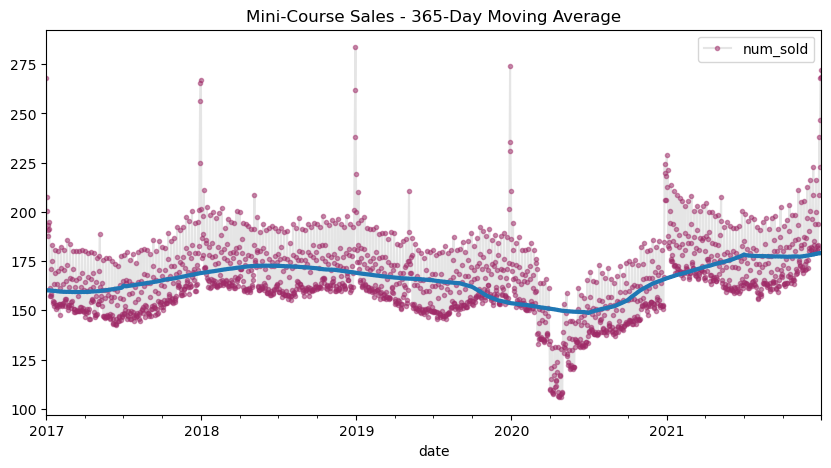

In [18]:
moving_average = average_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=185,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)


plot_params = {'color': '0.8',
 'style': '.-',
 'markeredgecolor': '#9F2B68',
 'markerfacecolor': '#9F2B68',
 'legend': True,
 'figsize': (10, 5)}

ax = average_sales.plot(**plot_params, alpha=0.5)
moving_average.plot(
    ax=ax, linewidth=3, title="Mini-Course Sales - 365-Day Moving Average", legend=False,
);

In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a squared trend model
dp = DeterministicProcess(
    index=y.index,       
    order=2,     
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 365-day forecast.
X_fore = dp.out_of_sample(steps=365)

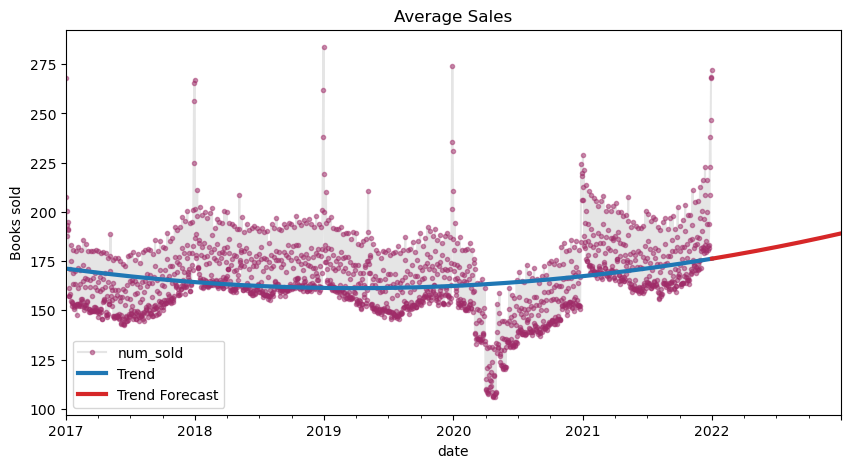

In [20]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="Books sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [21]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
             )
    return ax

In [22]:
X = average_sales.to_frame()
# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X["month"] = X.index.month

/tmp/ipykernel_20/372123915.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='num_sold'>

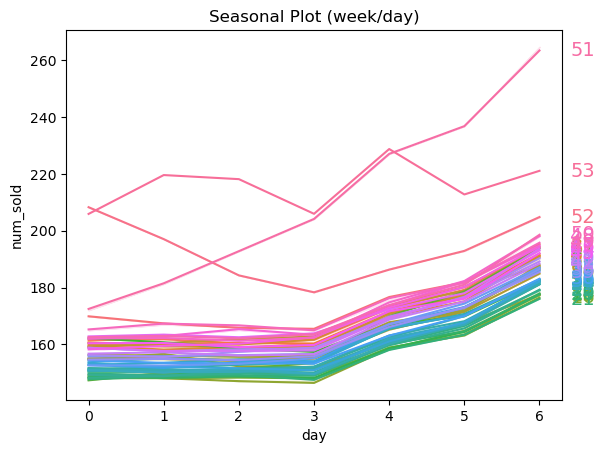

In [23]:
seasonal_plot(X, y="num_sold", period="week", freq="day")

<div style="color:#9F2B68; font-size:20px"><b>Week 51, 52 and 53</b> shows exceptional behavior is sales during all days of the week.
    </div>

/tmp/ipykernel_20/372123915.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


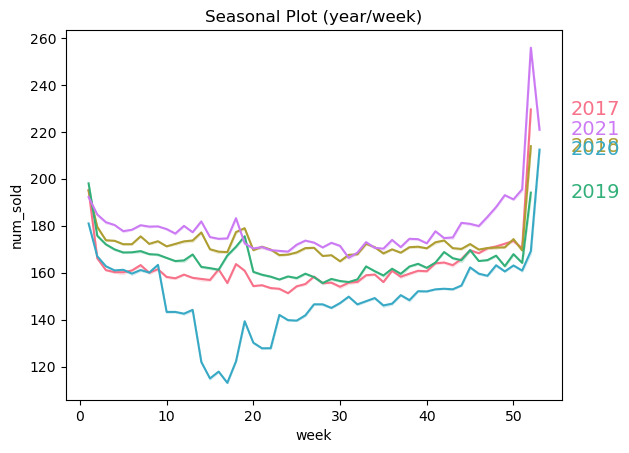

In [24]:
seasonal_plot(X, y="num_sold", period="year", freq="week");

<div style="color:#9F2B68; font-size:20px"><b>Week 51, 52 and 53</b> can see a huge spike in our seasonal plot which further confirms the seasonal increase in book sales for Christmas and new year
    </div>

/tmp/ipykernel_20/372123915.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


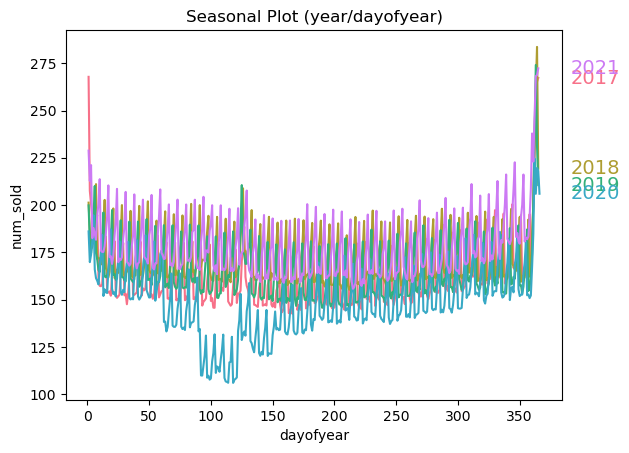

In [25]:
seasonal_plot(X, y="num_sold", period="year", freq="dayofyear");

<div style="color:#9F2B68; font-size:20px">Apart from December and January, there seems to be a small spike around <b>May</b> - Summer vacations perhaps?
    </div>

# 1.4.1 Periodogram

In [26]:
 def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="#9F2B68")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
                [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/tmp/ipykernel_20/2665294359.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


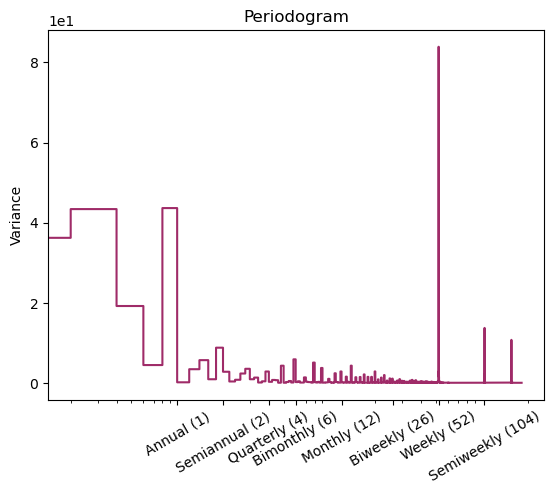

In [27]:
plot_periodogram(average_sales);

<div style="color:#9F2B68; font-size:20px">We can clearly notice a weekly season( higher sales during weekends) </div>

# 1.4.2 Holidays

In [28]:
#Get list of major holidays for ['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain'] and append to df 

def GetHolidays(df):
    
    # Analyzing country specific holidays:-
    Holidays = pd.DataFrame(columns = ['date', 'holiday_name', 'country'])
    country_list = df.country.unique();
    min_year = df.year.min()
    max_year = df.year.max()
    number_of_days = (df['date'].max() - df['date'].min()).days + 1
    date_list = [df['date'].min() + datetime.timedelta(days=day) for day in range(number_of_days)]

    for country in tqdm(country_list):
        for h in CountryHoliday(country, years = np.arange(min_year,max_year,1)).items():   
            i=len(Holidays)
            Holidays.loc[i,'date']=h[0]
            Holidays.loc[i,'holiday_name']=h[1]
            Holidays.loc[i,'country']=country


    Holidays['isHoliday'] = 1

    # Merge on unique combinations of date and country
    date_country = df[['date', 'country']].drop_duplicates().reset_index(drop=True)
    date_country['date_str'] = date_country['date'].astype(str)
    Holidays['date_str'] = Holidays['date'].astype(str)
    date_country_holidays = pd.merge(date_country, Holidays[['date_str', 'country', 'isHoliday','holiday_name']], how='left', on=['date_str', 'country'])

    # Merge back to the original DataFrame
    df = pd.merge(df, date_country_holidays[['date', 'country', 'isHoliday','holiday_name']], how='left', on=['date', 'country'])
    df['isHoliday'] = df['isHoliday'].fillna(0).astype(int)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    #Add Weekend
    df['Friday']=(df['dayname']=='Friday').astype(int) 
    df['Saturday']=(df['dayname']=='Saturday').astype(int) 
    df['Sunday']=(df['dayname']=='Sunday').astype(int)  
    return df

In [29]:
train_df = GetHolidays(train_df)
test_df= GetHolidays(test_df)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
print(len(train_df.query('date=="2017-01-01"')))

75


# 1.4.3 Visualising the Forecast

In [31]:
from statsmodels.tsa.deterministic import CalendarFourier

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
y = average_sales.copy() 

dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

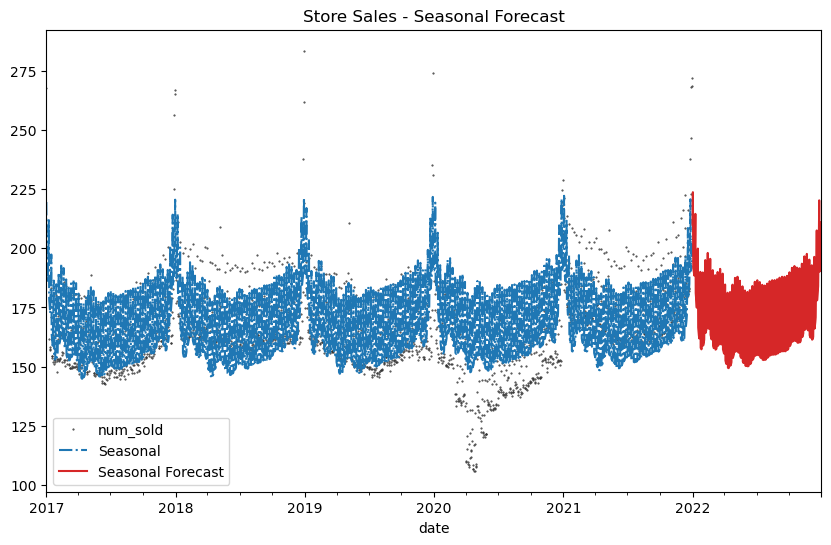

In [32]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=365)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

fig, ax = plt.subplots(figsize=(10, 6))

ax = y.plot(color='0.2', style='.',markersize=1, title="Store Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal",linestyle='-.')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3',linestyle='-')
_ = ax.legend()

# 1.4.4 Capturing COVID crisis

In [33]:
def GetCrisis(df):
    
    # Define the start and end dates of the crisis period
    crisis_start_date = pd.to_datetime('2020-02-01')
    crisis_end_date = pd.to_datetime('2020-06-30')

    # Create the 'IsCrisis' feature and set it as 1 for the crisis period, 0 otherwise
    df['IsCrisis'] = (df['date'] >= crisis_start_date) & (df['date'] <= crisis_end_date)
    df['IsCrisis'] = df['IsCrisis'].astype(int)

    return df

GetCrisis(train_df)
GetCrisis(test_df)

,id,date,country,store,product,year,month,dayofmonth,dayofweek,dayname,dayofyear,isHoliday,holiday_name,Friday,Saturday,Sunday,IsCrisis
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,Saturday,1,0,Not Holiday,0,1,0,0
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,Saturday,1,0,Not Holiday,0,1,0,0
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,Saturday,1,0,Not Holiday,0,1,0,0
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,Saturday,1,0,Not Holiday,0,1,0,0
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,Saturday,1,0,Not Holiday,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,Saturday,365,0,Not Holiday,0,1,0,0
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,Saturday,365,0,Not Holiday,0,1,0,0
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,Saturday,365,0,Not Holiday,0,1,0,0
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,Saturday,365,0,Not Holiday,0,1,0,0


# 1.4.5 Partial AutoCorrelation and Autocorrelation

/tmp/ipykernel_20/2185403589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value']=df['num_sold']


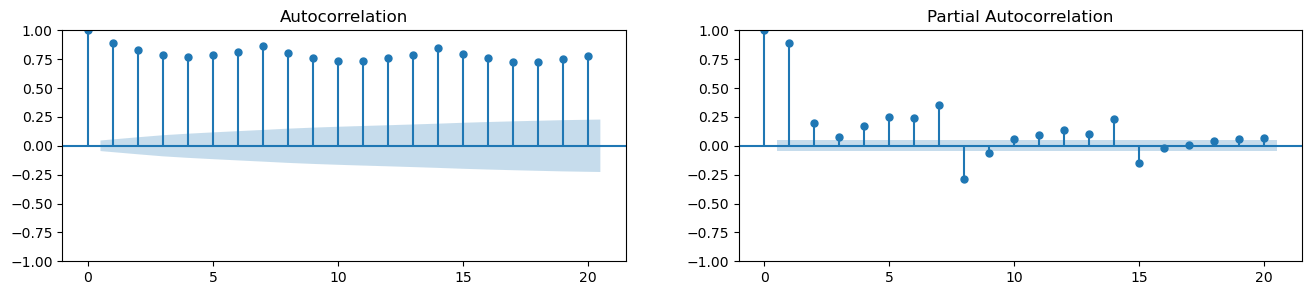

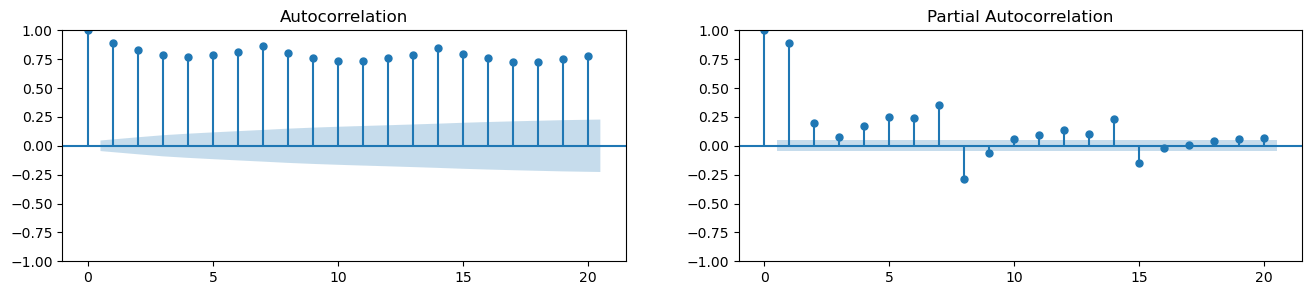

In [34]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = train_df[(train_df['country']=='Argentina')&(train_df['product']=='Using LLMs to Improve Your Coding')&(train_df['store']=='Kaggle Learn')]
df['value']=df['num_sold']

acf_20 = acf(df.value, nlags=20)
pacf_20 = pacf(df.value, nlags=20)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=20, ax=axes[0])
plot_pacf(df.value.tolist(), lags=20, ax=axes[1])

# 1.4.5 Lag Plots

/tmp/ipykernel_20/170909649.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss['value']=ss['num_sold']
/tmp/ipykernel_20/170909649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a10['value']=a10['num_sold']


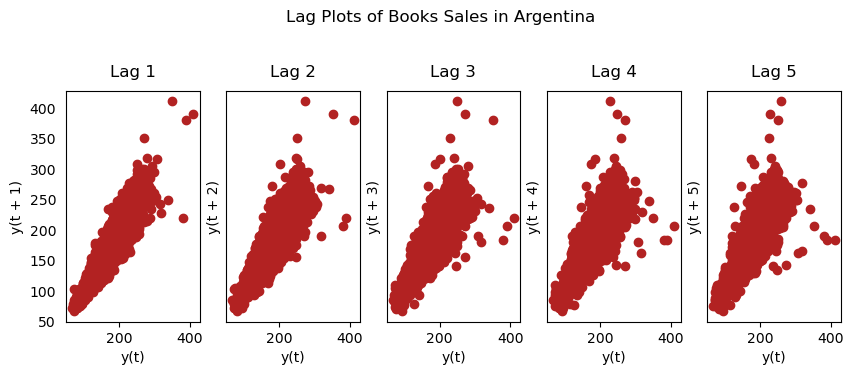

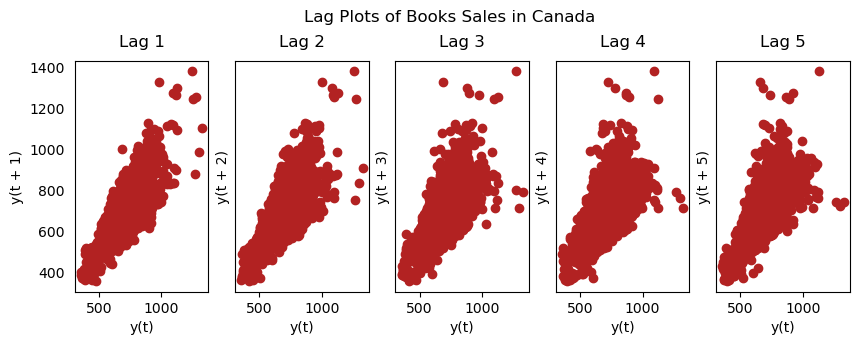

In [35]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

n_plots=5
ss = train_df[(train_df['country']=='Argentina')&(train_df['product']=='Using LLMs to Improve Your Coding')&(train_df['store']=='Kagglazon')]
ss['value']=ss['num_sold']
a10 = train_df[(train_df['country']=='Canada')&(train_df['product']=='Using LLMs to Improve Your Coding')&(train_df['store']=='Kagglazon')]
a10['value']=a10['num_sold']

fig, axes = plt.subplots(1, n_plots, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:n_plots]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Books Sales in Argentina\n', y=1.15)    

fig, axes = plt.subplots(1, n_plots, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:n_plots]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Books Sales in Canada', y=1.05)    
plt.show()

# 1.4.6 GDP

In [36]:
"""def get_gdp_per_capita(country,year):
    alpha3 = {'Argentina':'ARG', 'Canada':'CAN', 'Estonia':'EST', 'Japan':'JPN', 'Spain':'ESP'}
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

gdp = []
for country in train_df.country.unique():
    row = []
    for year in range(2017,2023):
        row.append(get_gdp_per_capita(country,year))
    gdp.append(row)

gdp = np.array(gdp)
gdp /= np.sum(gdp,axis=0)

rel_gdp_df = pd.DataFrame(gdp, index=train_df.country.unique(),columns=range(2017,2023))

for n in range(5):
    ax.plot(np.cumsum([1, 365] * 6), np.repeat(rel_gdp_df.iloc[n].to_numpy(), 2), 'k', linewidth=2)  
plt.show()"""

'def get_gdp_per_capita(country,year):\n    alpha3 = {\'Argentina\':\'ARG\', \'Canada\':\'CAN\', \'Estonia\':\'EST\', \'Japan\':\'JPN\', \'Spain\':\'ESP\'}\n    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)\n    response = requests.get(url).json()\n    return response[1][0][\'value\']\n\ngdp = []\nfor country in train_df.country.unique():\n    row = []\n    for year in range(2017,2023):\n        row.append(get_gdp_per_capita(country,year))\n    gdp.append(row)\n\ngdp = np.array(gdp)\ngdp /= np.sum(gdp,axis=0)\n\nrel_gdp_df = pd.DataFrame(gdp, index=train_df.country.unique(),columns=range(2017,2023))\n\nfor n in range(5):\n    ax.plot(np.cumsum([1, 365] * 6), np.repeat(rel_gdp_df.iloc[n].to_numpy(), 2), \'k\', linewidth=2)  \nplt.show()'

# 1.5 ARIMA

In [37]:
df = train_df[(train_df['country']=='Argentina')&(train_df['product']=='Using LLMs to Improve Your Coding')&(train_df['store']=='Kagglazon')]
series=pd.DataFrame()
series['value']=df['num_sold']
series=series.set_index(df['date'])
series.index = pd.to_datetime(series.index)

series


,value
date,
2017-01-01,340
2017-01-02,250
2017-01-03,267
2017-01-04,236
2017-01-05,247
...,...
2021-12-27,220
2021-12-28,223
2021-12-29,269


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1826
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7795.721
Date:                Thu, 13 Jul 2023   AIC                          15603.442
Time:                        00:45:54   BIC                          15636.498
Sample:                    01-01-2017   HQIC                         15615.635
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3697      0.017    -21.515      0.000      -0.403      -0.336
ar.L2         -0.2378      0.018    -13.342      0.000      -0.273      -0.203
ar.L3         -0.3155      0.015    -20.905      0.0

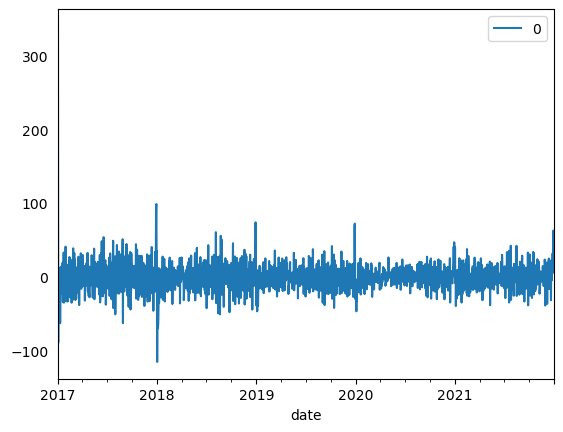

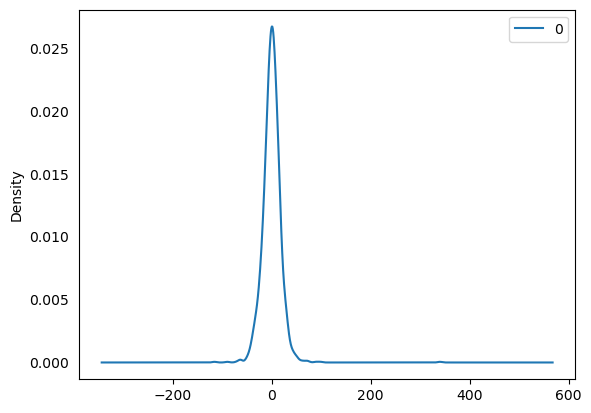

                 0
count  1826.000000
mean      0.076662
std      19.099619
min    -115.738866
25%      -9.696551
50%       0.118632
75%      10.057086
max     340.000000


In [38]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA (series, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

# 2. Preparing the Data

In [39]:
#Get entries per date - countries * store * product

n_entries=len(train_df.query('date=="2017-01-01"'))

In [40]:
print(train_df.shape)
print(test_df.shape)

(136950, 18)
(27375, 17)


In [41]:
train_df['num_sold'] = np.log1p(train_df['num_sold'])

In [42]:
#Creating Lag Features
full_data=pd.concat([train_df,test_df], axis=0,keys=('train','test'))

"""full_data['Lag_7'] = full_data['num_sold'].shift(n_entries*7).interpolate()
full_data['Lag_30'] = full_data['num_sold'].shift(n_entries*30).interpolate()
full_data['Lag_120'] = full_data['num_sold'].shift(n_entries*120).interpolate()
full_data['Lag_365'] = full_data['num_sold'].shift(n_entries*365).interpolate()"""

"full_data['Lag_7'] = full_data['num_sold'].shift(n_entries*7).interpolate()\nfull_data['Lag_30'] = full_data['num_sold'].shift(n_entries*30).interpolate()\nfull_data['Lag_120'] = full_data['num_sold'].shift(n_entries*120).interpolate()\nfull_data['Lag_365'] = full_data['num_sold'].shift(n_entries*365).interpolate()"

In [43]:
train_df = full_data.xs('train')
test_df = full_data.xs('test')

In [44]:
test_df.isna().sum()

id                  0
date                0
country             0
store               0
product             0
num_sold        27375
year                0
month               0
dayofmonth          0
dayofweek           0
dayname             0
dayofyear           0
isHoliday           0
holiday_name        0
Friday              0
Saturday            0
Sunday              0
IsCrisis            0
dtype: int64

In [45]:
to_drop = ['id','dayname']
train_df.drop(to_drop,axis=1,inplace=True)
test_df.drop(to_drop,axis=1,inplace=True)

/tmp/ipykernel_20/3998960069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(to_drop,axis=1,inplace=True)
/tmp/ipykernel_20/3998960069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(to_drop,axis=1,inplace=True)


In [46]:
train_df.set_index("date",inplace=True)
test_df.set_index("date",inplace=True)

In [47]:
X_train= train_df.drop('num_sold',axis=1)
y_train= train_df.num_sold
X_test=test_df.drop('num_sold',axis=1)

In [48]:
print(X_train.shape)
print(X_test.shape)

(136950, 14)
(27375, 14)


In [49]:
# SMAPE metric
def smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)) * 100)

smape_scorer = make_scorer(smape, greater_is_better=False)

# 3. Model Training

In [50]:
#Encoding
cat_cols = ['country', 'store', 'product','holiday_name']
encoder = LabelEncoder()
for col in cat_cols:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] =  encoder.transform(X_test[col])

In [51]:
def plot_predicted(X,y,test,pred):

    # Plotting actual values
    plt.plot(X.index, np.expm1(y), label='Training Data')
    plt.plot(test.index, np.expm1(pred), label='Forecasted Values')
    
    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.title('Forecasted Values')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

In [52]:
def model_training(model,model_name,X,y):
    print(f"\n\n--Staring training on {model_name}--")
    n_folds=5
    tscv = TimeSeriesSplit(n_splits=n_folds)
    scores = []
    pipe = Pipeline([
            #('scale',MinMaxScaler()),
            ('model',model)
        ])
    for fold,(train_index, test_index) in enumerate(tscv.split(X,y)):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        print(X_train.shape)
        pipe.fit(X_train, y_train)

        y_hat = pipe.predict(X_train)
        y_pred = pipe.predict(X_val)

        train_score= smape(y_train,y_hat)
        score = smape(y_val, y_pred)
        scores.append(score)
        print(f"Fold {fold+1}: SMAPE = {score} [Train]={train_score}")
    
    mean_score = np.mean(scores)
    print("\nMean SMAPE =", mean_score)
    
    #Test Prediction
    pipe.fit(X,y)
    plot_predicted(X,y,X_test,pipe.predict(X_test))

In [53]:
models = [
    ('cat',CatBoostRegressor(random_state=42, verbose=False)),
]



--Staring training on cat--
(22825, 14)
Fold 1: SMAPE = 3.0004335766327537 [Train]=0.9311748134394774
(45650, 14)
Fold 2: SMAPE = 1.9913218770959662 [Train]=0.9537866889603269
(68475, 14)
Fold 3: SMAPE = 2.4022766854044884 [Train]=0.981262708890538
(91300, 14)
Fold 4: SMAPE = 2.009582723147208 [Train]=1.0019213991885967
(114125, 14)
Fold 5: SMAPE = 1.7264461523671035 [Train]=1.0169929107088234

Mean SMAPE = 2.226012202929504


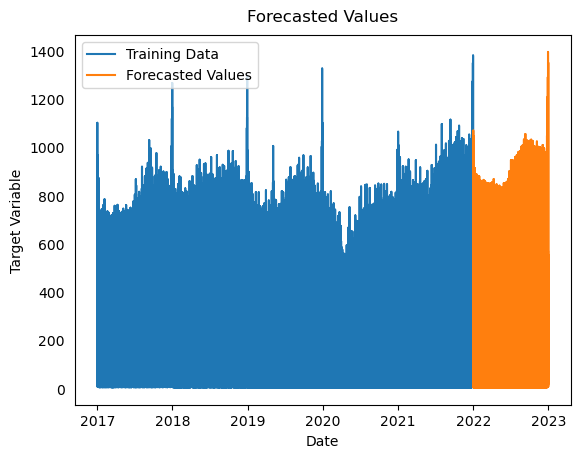

In [54]:
for label,model in models:
    model_training(model,label,X_train,y_train)

# 4. Final Submission

In [55]:
from sklearn.preprocessing import power_transform
final_model = CatBoostRegressor(random_state=42, verbose=False)
pipe = Pipeline([
            #('scale',MinMaxScaler()),
            ('model',final_model)
        ])
pipe.fit(X_train,y_train)

Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x79d0844e7160>)])

In [56]:
final_preds = pipe.predict(X_test)

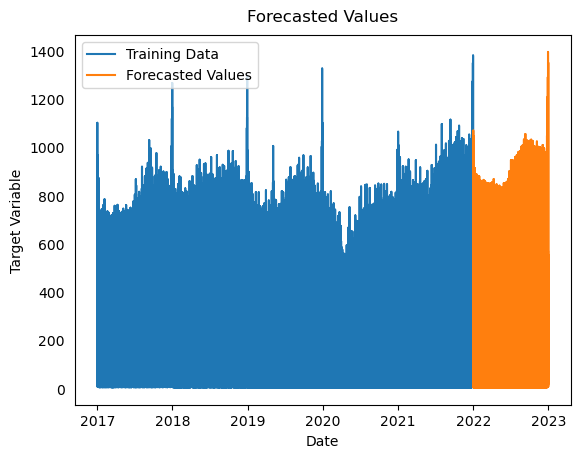

In [57]:
plot_predicted(X_train,y_train,X_test,final_preds)

In [58]:
submission_df.columns=["id","num_sold"]
submission_df["num_sold"]=np.expm1(final_preds)
submission_df.to_csv("submission.csv",index=False)

In [59]:
submission_df

,id,num_sold
0,136950,37.755424
1,136951,37.059122
2,136952,5.462440
3,136953,35.291734
4,136954,28.744834
...,...,...
27370,164320,744.657008
27371,164321,740.172777
27372,164322,115.697998
27373,164323,689.317385


# End of Notebook

<div style="color:#9F2B68; font-size:20px">If you find this notebook useful, kindly upvote to keep me motivated</div>

<div style="color:#953553; font-size:20px">
    <b>Coming Up...</b> <br/>
    - Forecasting and basic plot<br/>
    - Emphasizing impact of COVID
</div>